**Importing the Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE
from scipy.stats import pointbiserialr
from sklearn.datasets import make_classification

**Dataset Selection**

I downloaded the dataset from the provided reliable and accessible repository: https://www.kaggle.com/competitions/ml-with-python-course-project/data?select=train.csv

In [2]:
# Load training dataset
train_df = pd.read_csv('train.csv')

In [3]:
# Dataset overview
print("Dataset shape:", train_df.shape)
print("First five rows:")
print(train_df.head())
print("\nDataset information:")
train_df.info()

Dataset shape: (215, 15)
First five rows:
   sl_no  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1       0  67.00   Others  91.00   Others  Commerce     58.00   
1      2       0  79.33  Central  78.33   Others   Science     77.48   
2      3       0  65.00  Central  68.00  Central      Arts     64.00   
3      4       0  56.00  Central  52.00  Central   Science     52.00   
4      5       0  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80      Placed  270000.0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28      Placed  200000.0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80      Placed  250000.0  
3   Sci&Tech     No     66.0         Mkt&HR  59.43  Not Placed       NaN  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50      Placed  425000.0  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215


**Categorical Target Variable:** The dataset is appropriate for the task as it includes a clear categorical target variable, which is status. This variable indicates whether a student was "Placed" or "Not Placed," making it suitable for classification tasks aimed at predicting placement outcomes. Therefore, it meets the requirement of having a well-defined categorical target variable.

**Dataset Size:** The dataset consists of 215 rows and 15 columns (Dataset shape: (215, 15)). The number of rows is moderate, allowing for both meaningful statistical analysis and training/testing without overwhelming computational resources.

**Dataset Complexity:** The dataset includes a mix of numerical and categorical features, such as ssc_p, hsc_p, and degree_p (numerical), as well as gender, ssc_b, degree_t, and workex (categorical). This diversity in feature types provides sufficient complexity for exploring a variety of feature engineering and preprocessing techniques.

**Data Preprocessing**

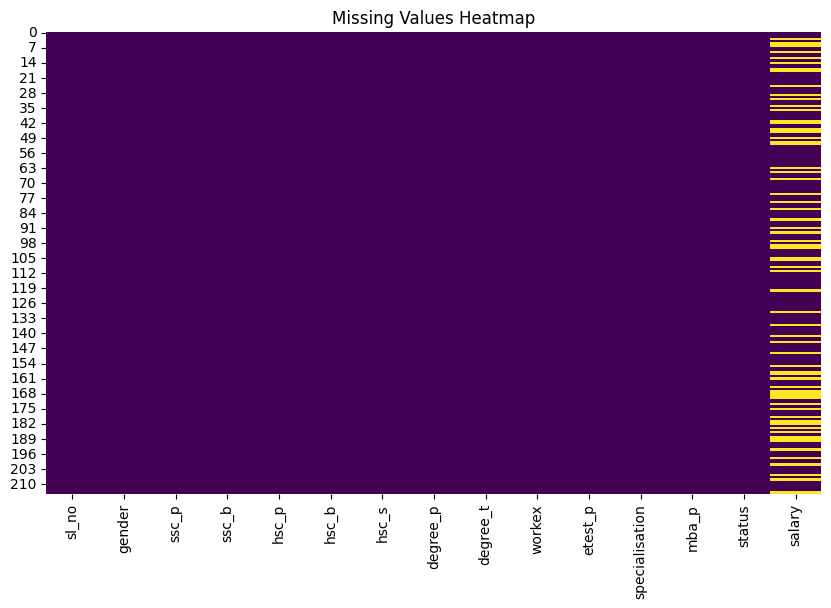

In [4]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

Purple Regions:These represent cells with no missing values. Most of the columns in your dataset appear to have complete data with no missing values.

Yellow Lines in the salary Column: The yellow segments in the salary column indicate missing values. It is clear that there are significant missing values specifically in the salary column.

**This means that we need to handle missing values in the salary column.**

In [5]:
# Summary statistics
print("\nStatistical Summary:")
print(train_df.describe())


Statistical Summary:
            sl_no      gender       ssc_p       hsc_p    degree_p     etest_p  \
count  215.000000  215.000000  215.000000  215.000000  215.000000  215.000000   
mean   108.000000    0.353488   67.303395   66.333163   66.370186   72.100558   
std     62.209324    0.479168   10.827205   10.897509    7.358743   13.275956   
min      1.000000    0.000000   40.890000   37.000000   50.000000   50.000000   
25%     54.500000    0.000000   60.600000   60.900000   61.000000   60.000000   
50%    108.000000    0.000000   67.000000   65.000000   66.000000   71.000000   
75%    161.500000    1.000000   75.700000   73.000000   72.000000   83.500000   
max    215.000000    1.000000   89.400000   97.700000   91.000000   98.000000   

            mba_p         salary  
count  215.000000     148.000000  
mean    62.278186  288655.405405  
std      5.833385   93457.452420  
min     51.210000  200000.000000  
25%     57.945000  240000.000000  
50%     62.000000  265000.000000  
75%

There are 215 rows in the dataset, but the salary column only has 148 non-null values, meaning 67 entries are missing. This is consistent with the missing value visualization from the previous heatmap.

The salary column shows a wide range from 20,000 to 940,000. The mean and median (265,000) suggest that there might be some outliers on the higher end. This variability could affect the model's ability to generalize.

Most of the features have different value ranges, so scaling is essential to ensure fair weight during model training.

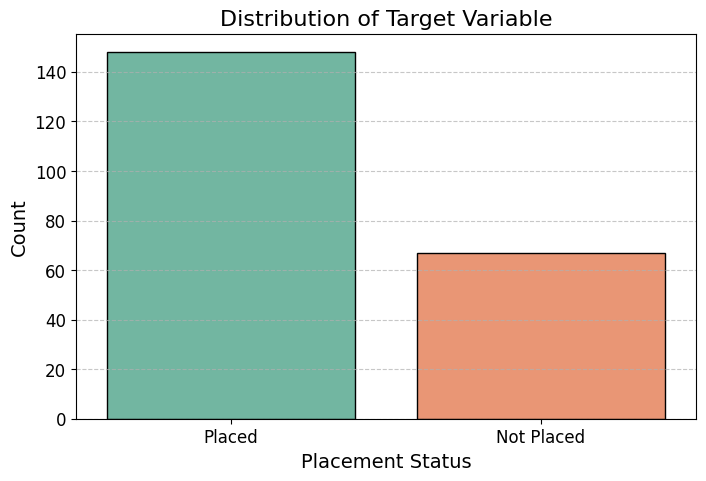

In [6]:
# Distribution of target variable
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='status', palette='Set2', edgecolor='black', hue='status')
plt.title("Distribution of Target Variable", fontsize=16)
plt.xlabel("Placement Status", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The distribution indicates that there are significantly more "Placed" students compared to "Not Placed" students.
This is a moderate class imbalance, which means that the model might tend to favor predicting "Placed" more often because it has more examples to learn from.

In [7]:
# Handle missing values in the salary column
train_df['salary'] = train_df['salary'].fillna(train_df['salary'].median())  # Impute missing values in 'salary' with median

# Validate that the salary column has no missing values
print("\nMissing values in 'salary' column after imputation:", train_df['salary'].isnull().sum())


Missing values in 'salary' column after imputation: 0


In [8]:
# Encode categorical variables to avoid possible errors, excluding the target variable 'status'
label_encoder = LabelEncoder()
categorical_cols = train_df.select_dtypes(include='object').columns.drop('status')
for col in categorical_cols:
    label_encoder.fit(train_df[col])
    train_df[col] = label_encoder.transform(train_df[col])

# Validate that the categorical features were correctly encoded
print("Verification of encoded categorical features (showing first few rows and unique values for each column):")
for col in categorical_cols:
    print(f"{col} unique values after encoding: {train_df[col].unique()}")
    print(train_df[[col]].head())

Verification of encoded categorical features (showing first few rows and unique values for each column):
ssc_b unique values after encoding: [1 0]
   ssc_b
0      1
1      0
2      0
3      0
4      0
hsc_b unique values after encoding: [1 0]
   hsc_b
0      1
1      1
2      0
3      0
4      0
hsc_s unique values after encoding: [1 2 0]
   hsc_s
0      1
1      2
2      0
3      2
4      1
degree_t unique values after encoding: [2 0 1]
   degree_t
0         2
1         2
2         0
3         2
4         0
workex unique values after encoding: [0 1]
   workex
0       0
1       1
2       0
3       0
4       0
specialisation unique values after encoding: [1 0]
   specialisation
0               1
1               0
2               0
3               1
4               0


In [9]:
print(train_df.head())

   sl_no  gender  ssc_p  ssc_b  hsc_p  hsc_b  hsc_s  degree_p  degree_t  \
0      1       0  67.00      1  91.00      1      1     58.00         2   
1      2       0  79.33      0  78.33      1      2     77.48         2   
2      3       0  65.00      0  68.00      0      0     64.00         0   
3      4       0  56.00      0  52.00      0      2     52.00         2   
4      5       0  85.80      0  73.60      0      1     73.30         0   

   workex  etest_p  specialisation  mba_p      status    salary  
0       0     55.0               1  58.80      Placed  270000.0  
1       1     86.5               0  66.28      Placed  200000.0  
2       0     75.0               0  57.80      Placed  250000.0  
3       0     66.0               1  59.43  Not Placed  265000.0  
4       0     96.8               0  55.50      Placed  425000.0  


In [10]:
# Prepare features and target variables
X = train_df.drop('status', axis=1)
y = train_df['status']

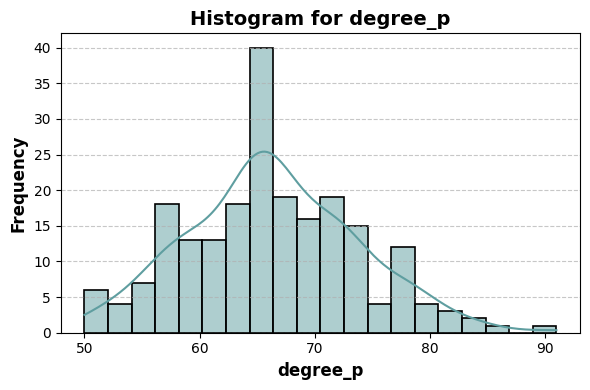

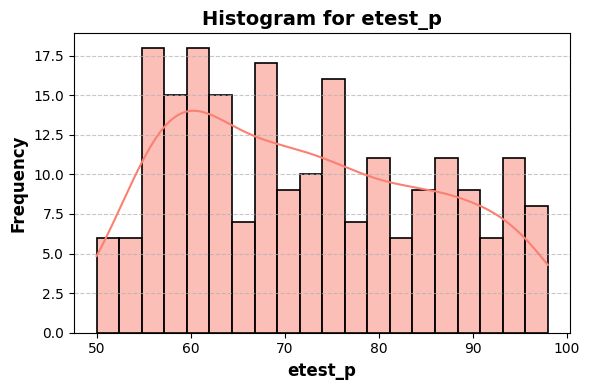

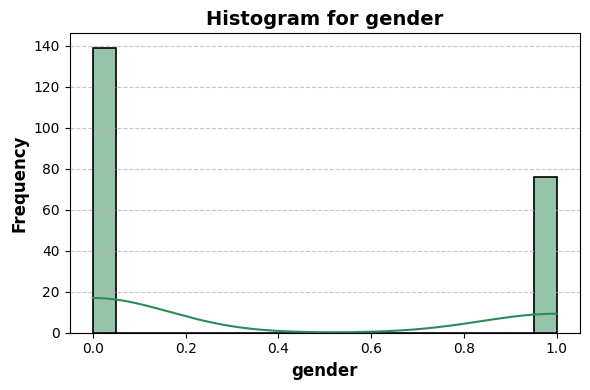

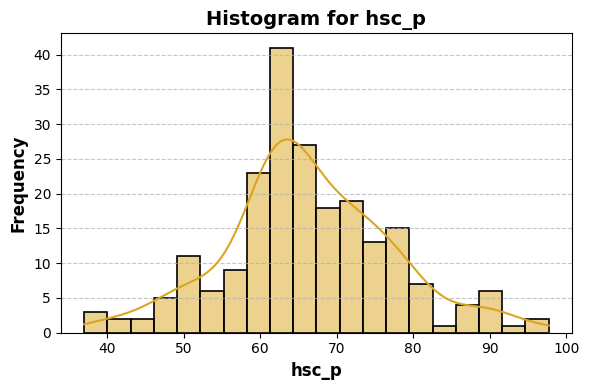

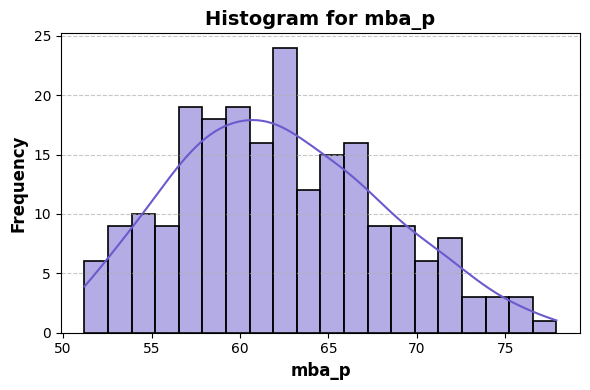

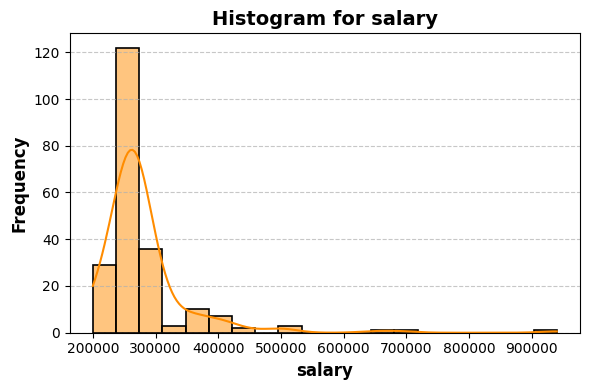

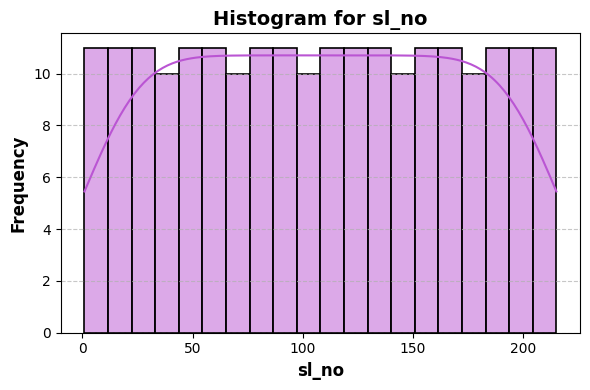

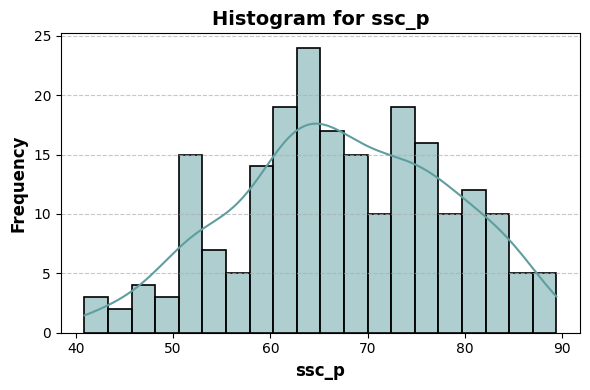

In [11]:
# Plot histograms for each numerical feature to observe their distributions, excluding encoded features
colors = ['cadetblue', 'salmon', 'seagreen', 'goldenrod', 'slateblue', 'darkorange', 'mediumorchid']
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.difference(categorical_cols)
for i, col in enumerate(numerical_cols):
    plt.figure(figsize=(6, 4))
    sns.histplot(X[col], kde=True, color=colors[i % len(colors)], bins=20, edgecolor='black', linewidth=1.2)
    plt.title(f'Histogram for {col}', fontsize=14, weight='bold')
    plt.xlabel(col, fontsize=12, weight='bold')
    plt.ylabel('Frequency', fontsize=12, weight='bold')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

**Salary:** The salary feature shows a highly skewed distribution towards the lower end, with the majority of the salaries clustered between 200,000 and 400,000. This indicates that most students received relatively lower salaries, with only a few earning higher salaries.

**MBA Percentage (mba_p):** The mba_p feature has a roughly normal distribution, with the highest frequency around 60-65. This indicates that the MBA scores are generally spread out around this range, with fewer students having extremely low or high scores.

**E-Test Percentage (etest_p):** The histogram for etest_p shows a multimodal distribution, indicating that students' performance in the employment test is somewhat spread out across different levels. There are several peaks, suggesting clusters of scores.

**Degree Percentage (degree_p):** The degree_p feature also displays a roughly normal distribution, with a peak around 60-65. This suggests that most students' degree scores fall within this range, and only a few students have very low or very high scores.

**HSC Percentage (hsc_p):** The hsc_p feature has a similar distribution to degree_p, with a concentration of students scoring around 60-70. The distribution is slightly skewed to the right, meaning there are fewer students with exceptionally high scores.

**SSC Percentage (ssc_p):** The ssc_p histogram indicates that the scores are moderately distributed, with a peak between 60-70. This feature has a spread of scores, indicating some variation among students’ SSC performance.

**Serial Number (sl_no):** The sl_no feature is uniformly distributed, which makes sense as it is an identifier and does not have meaningful variation in the context of student placement.

In [12]:
# Compute point biserial correlation between the numerical features and the categorical target
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.difference(categorical_cols)
print("Point Biserial Correlation between Numerical Features and Target Variable 'status':")
for col in numerical_cols:
    corr, _ = pointbiserialr(X[col], y.apply(lambda x: 1 if x == 'Placed' else 0))
    print(f"Correlation between '{col}' and 'status': {corr:.2f}")

Point Biserial Correlation between Numerical Features and Target Variable 'status':
Correlation between 'degree_p' and 'status': 0.48
Correlation between 'etest_p' and 'status': 0.13
Correlation between 'gender' and 'status': -0.09
Correlation between 'hsc_p' and 'status': 0.49
Correlation between 'mba_p' and 'status': 0.08
Correlation between 'salary' and 'status': 0.14
Correlation between 'sl_no' and 'status': -0.03
Correlation between 'ssc_p' and 'status': 0.61


As we can see in the correlation between the features and the target variable it could be beneficial to exclude the features with very low correlation like 'gender', 'mba_p', and 'sl_no'.

On the other hand, features like 'degree_p', 'hsc_p', and 'ssc_p' have a strong positive correlation with the target variable, therefore, it will be very important to include them and pay special attention to them in our model.

In [13]:
# Feature Selection Based on Point Biserial Correlation Analysis
# Exclude features with very low correlation to the target variable
X = X.drop(['gender', 'mba_p', 'sl_no'], axis=1)

In [14]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

**SMOTE (Synthetic Minority Over-sampling Technique)**

**Synthetic Sample Generation:** Instead of simply replicating the minority samples, SMOTE generates new synthetic examples by interpolating between existing ones. It selects two or more similar data points in the minority class and creates a new data point that lies between them.

**Data Balancing:** By using SMOTE, the goal is to create a balanced dataset where the number of samples in each class is roughly equal, leading to a model that can generalize better and not be biased towards the majority class.

In [15]:
# Verify that the class distribution is now balanced after SMOTE
print("\nClass distribution after SMOTE:")
print(y_resampled.value_counts())


Class distribution after SMOTE:
status
Placed        148
Not Placed    148
Name: count, dtype: int64


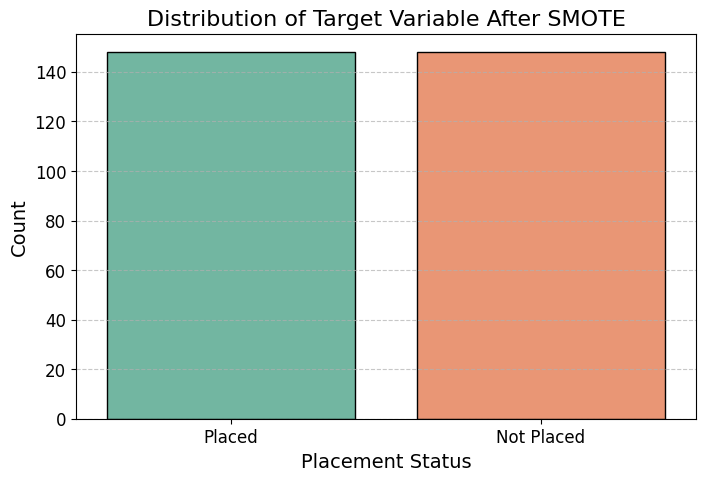

In [16]:
# Plot distribution of target variable after SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y_resampled, hue=y_resampled, palette='Set2', edgecolor='black', dodge=False, legend=False)
plt.title("Distribution of Target Variable After SMOTE", fontsize=16)
plt.xlabel("Placement Status", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

As we can see in the above chart the target variable is now balanced after SMOTE.

In [17]:
# Splitting the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [18]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

**Model Selection**

In [19]:
# Model Selection and Training
log_reg = LogisticRegression()
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

**Models Explanation:**

*Logistic Regression:*

A linear model used for binary classification. It predicts the probability of the target variable (status) being 'Placed' or 'Not Placed'.

*Decision Tree Classifier:*

A non-linear model that uses decision nodes and branches to make classifications. It can capture complex relationships in the data that may not be easily represented by linear models.

*Random Forest Classifier:*

An ensemble model consisting of multiple decision trees. It helps in reducing overfitting that might be present in individual decision trees by averaging the predictions from multiple trees.

In [20]:
# Hyperparameter tuning using GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

**Hyperparameter Grid Definition:**

*For Random Forest (param_grid_rf):*

n_estimators: Number of trees in the forest. The values tested are 50, 100, and 150.

max_depth: Maximum depth of the trees. The values tested are None (no limit), 10, and 20.

min_samples_split: Minimum number of samples required to split an internal node. The values tested are 2, 5, and 10.


*For Decision Tree (param_grid_dt):*

max_depth: Maximum depth of the decision tree. The values tested are None, 10, and 20.

min_samples_split: Minimum number of samples required to split an internal node. The values tested are 2, 5, and 10.

In [21]:
# Tuning Random Forest
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=3, scoring='accuracy')
grid_rf.fit(X_train, y_train)
rf_clf = grid_rf.best_estimator_

In [22]:
# Tuning Decision Tree
grid_dt = GridSearchCV(dt_clf, param_grid_dt, cv=3, scoring='accuracy')
grid_dt.fit(X_train, y_train)
dt_clf = grid_dt.best_estimator_

GridSearchCV is used to find the optimal combination of hyperparameters by performing a grid search over the parameter values specified in param_grid_rf and param_grid_dt.

cv=3 specifies that 3-fold cross-validation will be used to assess the performance of each hyperparameter combination.

scoring='accuracy' is the metric used to evaluate the model performance during hyperparameter tuning.

**Model Training**

In [23]:
# Train each model
log_reg.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)

All three models are trained using the .fit() function on X_train and y_train. After training, these models can be evaluated and used to predict placement status for new students.

This training process aims to compare different modeling approaches to determine which one provides the best performance for predicting student placements.

*Fit GridSearch to Training Data:*

The Random Forest and Decision Tree models are tuned by fitting them to the training data (X_train, y_train).

The best estimator (rf_clf for Random Forest and dt_clf for Decision Tree) is then chosen based on the results from GridSearchCV.

**Model Evaluation**

**In this case, Recall is the most important metric to consider.** The goal of this project is to predict whether a student will be placed or not. Missing out on predicting students who are likely to get placed (i.e., false negatives) could lead to fewer opportunities being provided to qualified students.

**F1 Score is also important** here because it is a balance between Precision and Recall, ensuring that the model is not only good at predicting positive instances but also maintaining quality predictions. However, in this case, maximizing Recall should be prioritized slightly above other metrics.

In [24]:
# Model Evaluation

def evaluate_model(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
    print(f"Precision: {precision_score(y_val, y_pred, pos_label='Placed'):.2f}")
    print(f"Recall: {recall_score(y_val, y_pred, pos_label='Placed'):.2f}")
    print(f"F1 Score: {f1_score(y_val, y_pred, pos_label='Placed'):.2f}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


Logistic Regression Metrics:
Accuracy: 0.77
Precision: 0.71
Recall: 0.77
F1 Score: 0.74
Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.81      0.76      0.79        34
      Placed       0.71      0.77      0.74        26

    accuracy                           0.77        60
   macro avg       0.76      0.77      0.76        60
weighted avg       0.77      0.77      0.77        60



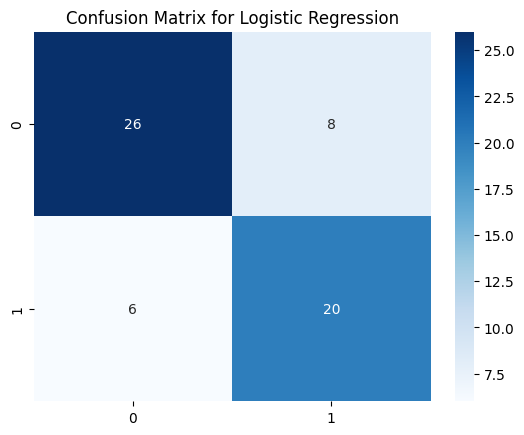


Decision Tree Metrics:
Accuracy: 0.92
Precision: 0.89
Recall: 0.92
F1 Score: 0.91
Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.94      0.91      0.93        34
      Placed       0.89      0.92      0.91        26

    accuracy                           0.92        60
   macro avg       0.91      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



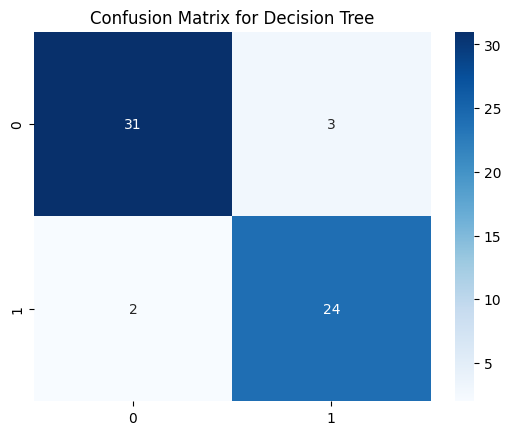


Random Forest Metrics:
Accuracy: 0.92
Precision: 0.86
Recall: 0.96
F1 Score: 0.91
Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.97      0.88      0.92        34
      Placed       0.86      0.96      0.91        26

    accuracy                           0.92        60
   macro avg       0.91      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



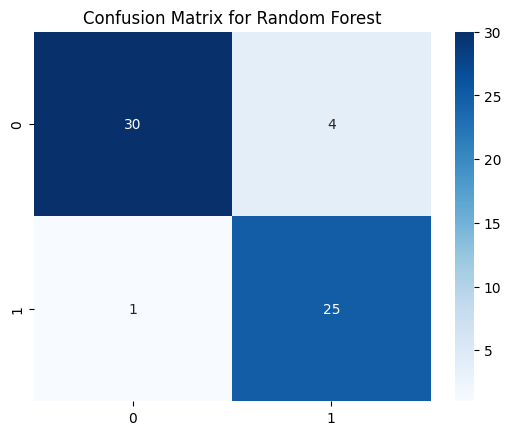


Voting Classifier Metrics:
Accuracy: 0.92
Precision: 0.86
Recall: 0.96
F1 Score: 0.91
Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.97      0.88      0.92        34
      Placed       0.86      0.96      0.91        26

    accuracy                           0.92        60
   macro avg       0.91      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



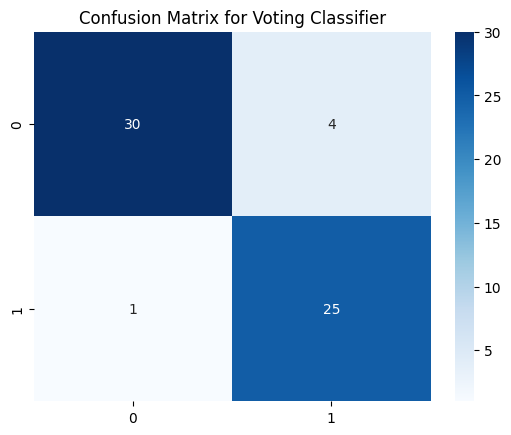

In [25]:
# Evaluate all models
models = [
    (log_reg, "Logistic Regression"),
    (dt_clf, "Decision Tree"),
    (rf_clf, "Random Forest"),
    (VotingClassifier(estimators=[('lr', log_reg), ('dt', dt_clf), ('rf', rf_clf)], voting='hard'), "Voting Classifier")
]

for model, name in models:
    model.fit(X_train, y_train)
    evaluate_model(model, X_val, y_val, name)

**Analysis of Confusion Matrices:**



*   Logistic Regression has the most false positives (8) and false negatives (6) among all models, which impacts both its precision and recall.
This indicates that the model struggles to correctly predict both 'Placed' and 'Not Placed' cases, which is reflected in its relatively lower overall performance metrics compared to the other models.
*   The Decision Tree has fewer misclassifications compared to Logistic Regression. False positives (3) and false negatives (2) are relatively low, showing that the model has a good balance between precision and recall. The high number of true negatives (31) indicates effective prediction of 'Not Placed' cases.

*   Random Forest performed very well with only 1 false negative, indicating strong recall. The model has 4 false positives, which is still quite low, contributing to a balanced performance across both classes.
*   The Voting Classifier has identical metrics to the Random Forest model. Combining multiple models helped achieve high recall with only 1 false negative, showing that it can reliably identify most of the students who should be placed. The number of true positives and true negatives is also high, indicating consistent performance in predicting both outcomes.





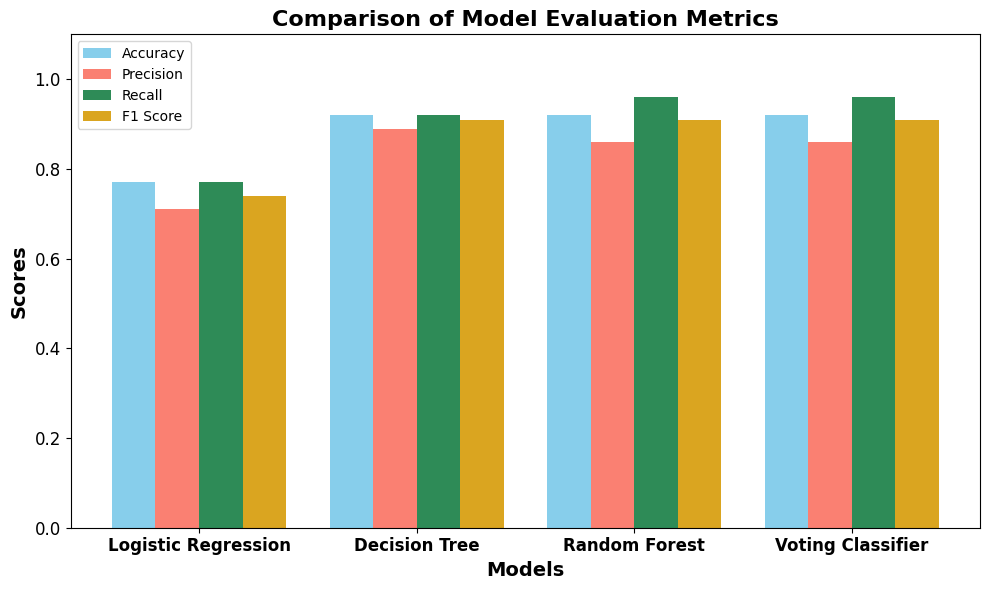

In [26]:
# Visualize model evaluation metrics
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "Voting Classifier"]
accuracies = [0.77, 0.92, 0.92, 0.92]
precisions = [0.71, 0.89, 0.86, 0.86]
recalls = [0.77, 0.92, 0.96, 0.96]
f1_scores = [0.74, 0.91, 0.91, 0.91]

plt.figure(figsize=(10, 6))

x = np.arange(len(model_names))
width = 0.2

plt.bar(x - 1.5 * width, accuracies, width, label='Accuracy', color='skyblue')
plt.bar(x - 0.5 * width, precisions, width, label='Precision', color='salmon')
plt.bar(x + 0.5 * width, recalls, width, label='Recall', color='seagreen')
plt.bar(x + 1.5 * width, f1_scores, width, label='F1 Score', color='goldenrod')

plt.xlabel('Models', fontsize=14, weight='bold')
plt.ylabel('Scores', fontsize=14, weight='bold')
plt.title('Comparison of Model Evaluation Metrics', fontsize=16, weight='bold')
plt.xticks(x, model_names, fontsize=12, weight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()

**Analysis of Evaluation Metrics:**

**Logistic Regression:**

The Logistic Regression model has moderate accuracy and F1-score. It has lower precision compared to recall, meaning it has a higher rate of false positives.

*The lower scores compared to other models indicate that Logistic Regression might not be able to capture the complexities of the dataset adequately.*

**Decision Tree:**

The Decision Tree classifier significantly outperforms Logistic Regression. The accuracy and F1-score are high, indicating good overall model performance.

*It balances precision and recall well, suggesting it effectively differentiates between 'Placed' and 'Not Placed' students.*

**Random Forest:**

The Random Forest model has similar accuracy and F1-score to the Decision Tree, but with slightly higher recall (0.96).

*This means the model is effective at identifying students who are 'Placed', with fewer false negatives, making it better at capturing all positive instances.*

**Voting Classifier:**

The Voting Classifier aggregates the predictions from Logistic Regression, Decision Tree, and Random Forest, resulting in similar performance to the Random Forest.

*This suggests that the ensemble approach stabilizes the model performance, leveraging the strengths of each individual classifier.*

**Comparison of Models:**

Best Model: Both the Random Forest and Voting Classifier performed equally well, achieving the highest recall, accuracy, and F1-score. These models are most capable of accurately predicting student placement.

Logistic Regression has the lowest performance, which is likely due to its inability to capture complex relationships in the dataset.

The Decision Tree model performs well but has a slightly lower recall compared to Random Forest, suggesting it may not capture all positive cases effectively.

GitHub Repository: https://github.com/JuanSCampos/Neural-Networks-and-Deep-Learning_Assignment-2_Juan-Campos.git